# Synthetic Generation of Data

- This file contains the code needed to generate all synthetic problem information in a specific format used in later methodology. 

#### RecipeTable

Recipe|Machine1_ProcessingUnitsPerMinute|Machine2_ProcessingUnitsPerMinute|Machine1_SetupTemperature|Machine2_SetupTemperature

In [5]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import kmeans1d # for aggregating back to clusters for recipe temperatures (ML)

import os


# Set seed
np.random.seed(121)

In [393]:
# Set a simSize
simSize = 20 # Recipes

# Triangular
left, mode, right = (0, 0.001, 10)
col1= np.random.triangular(left = left, 
                     mode = mode,
                     right = right,
                     size = simSize).astype('int')
col2= np.random.triangular(left = left, 
                     mode = mode,
                     right = right,
                     size = simSize).astype('int')

# Ensure no zeros overlap
for i in range(simSize):
    if col1[i] == 0 and col2[i] == 0: # if both are 0's
        if np.random.rand() > 0.5:  # Random change
            col1[i] = 1  # Change col1 to 1
        else:
            col2[i] = 1  # Change col2 to 1

# display df
df = pd.DataFrame({
    'Machine1_ProcessUnitsPerMinute': col1,
    'Machine2_ProcessUnitsPerMinute': col2
}, index=np.arange(1, simSize + 1)) 
df.index.name = 'Recipe'
display(df)


,Machine1_ProcessUnitsPerMinute,Machine2_ProcessUnitsPerMinute
Recipe,,
1,0,1
2,1,1
3,1,0
4,0,3
5,5,5
6,2,5
7,3,7
8,4,4
9,1,4


In [2]:

def n_mode_sampling(dist_params_list, min_samples_per_mode, 
                    n_total_samples, title='Empirical Distribution', x_label='Value', seed=121, ShowPlot = False):
    """
    Generates and samples from multiple distributions, each defined with custom parameters.
    
    dist_params_list: List of dictionaries containing the distribution parameters. 
                      Each dictionary should have the following keys:
                      - 'dist_type': The type of distribution ('normal', 'uniform', 'exponential', 'poisson').
                      - For 'normal': 'mean' and 'std' (standard deviation).
                      - For 'uniform': 'low' and 'high'.
                      - For 'exponential': 'scale' (mean of the distribution).
                      - For 'poisson': 'lambda' (rate of occurrence).
                      - 'n_samples': Number of samples for this mode.
                      - 'rounding_base': Base to round the samples (e.g., 10, 25, etc.).
    
    min_samples_per_mode: Minimum samples per mode to be included in the final selection (int).
    n_total_samples: Total number of samples to be generated across all modes (int).
    title: Title for the plot (str).
    x_label: X-axis label (str).
    seed: Random seed for reproducibility (int).
    """
    np.random.seed(seed)  # Set random seed

    def round_to_nearest(x, base):
        return base * np.round(x / base)  # Round to nearest base

    data = []  # Store samples
    
    # Loop over each mode's parameters
    for dist_params in dist_params_list:
        dist_type = dist_params['dist_type']  # Get distribution type
        n_samples = dist_params['n_samples']  # Get number of samples
        rounding_base = dist_params['rounding_base']  # Get rounding base
        
        # Generate samples based on distribution type
        if dist_type == 'normal':
            mean = dist_params['mean']
            std = dist_params['std']
            samples = np.random.normal(mean, std, n_samples)
        elif dist_type == 'uniform':
            low = dist_params['low']
            high = dist_params['high']
            samples = np.random.uniform(low, high, n_samples)
        elif dist_type == 'exponential':
            scale = dist_params['scale']
            samples = np.random.exponential(scale, n_samples)
        elif dist_type == 'poisson':
            lam = dist_params['lambda']
            samples = np.random.poisson(lam, n_samples)
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")
        
        # Round samples
        samples = round_to_nearest(samples, rounding_base)
        data.append(samples)  # Append samples

    combined_data = np.hstack(data)  # Combine all data

    # Calculate remaining samples
    n_modes = len(dist_params_list)  # Infer number of modes
    remaining_samples = n_total_samples - (n_modes * min_samples_per_mode)  # Remaining samples
    final_samples = []  # Store final samples

    # Add minimum samples per mode
    for mode_data in data:
        mode_samples = np.random.choice(mode_data, size=min_samples_per_mode, replace=False)  # Min samples
        final_samples.extend(mode_samples)  # Add to final samples

    # Add extra samples
    additional_samples = np.random.choice(combined_data, size=remaining_samples, replace=True)  # Extra samples
    final_samples.extend(additional_samples)  # Add extra samples

    final_samples = np.array(final_samples)  # Convert to array
    np.random.shuffle(final_samples)  # Shuffle final samples

    if ShowPlot: # Plot histogram
        plt.hist(
            combined_data,
            bins=50,  # Number of bins
            density=True,  # Normalize
            alpha=0.7,
            color='lightblue',
            edgecolor='black',
            label='Empirical Distribution'
        )
    
        # Prepare stacked dots
        unique_samples, counts = np.unique(final_samples, return_counts=True)  # Unique samples
        x_positions = []  # X positions
        y_positions = []  # Y positions
    
        for x_val, count in zip(unique_samples, counts):
            x_positions.extend([x_val] * count)  # Set x values
            y_positions.extend(range(count))  # Set y values
    
        # Scale y positions
        max_density = plt.gca().get_ylim()[1]  # Y-axis limit
        y_scale = max_density / (max(counts) * 2)  # Scaling factor
        y_positions = np.array(y_positions) * y_scale  # Apply scaling
    
        # Plot stacked dots
        plt.scatter(
            x_positions,
            y_positions,
            color='red',
            marker='o',
            s=100,
            label='Sampled Recipes'
        )
    
        plt.title(title)  # Set title
        plt.xlabel(x_label)  # Set x-axis label
        plt.ylabel('Density')
        plt.legend()
        plt.grid(False)
        plt.show()

    return final_samples

# # Test usage (KEEP FOR REFERENCE):
# dist_params_list = [
#     {'dist_type': 'normal', 'mean': 10, 'std': 5, 'n_samples': 500, 'rounding_base': 10},        # Normal distribution
#     {'dist_type': 'uniform', 'low': 80, 'high': 120, 'n_samples': 1000, 'rounding_base': 10},    # Uniform distribution
#     {'dist_type': 'exponential', 'scale': 100, 'n_samples': 1500, 'rounding_base': 10},          # Exponential distribution
#     {'dist_type': 'poisson', 'lambda': 200, 'n_samples': 1000, 'rounding_base': 25}              # Poisson distribution
# ]
# min_samples_per_mode = 3
# n_total_samples = 20

# # Call function
# n_mode_sampling(dist_params_list=dist_params_list,
#                                 min_samples_per_mode=min_samples_per_mode,
#                                 n_total_samples=n_total_samples,
#                                 title='Custom n-Mode Distribution',
#                                 x_label='Temperature', ShowPlot=True)


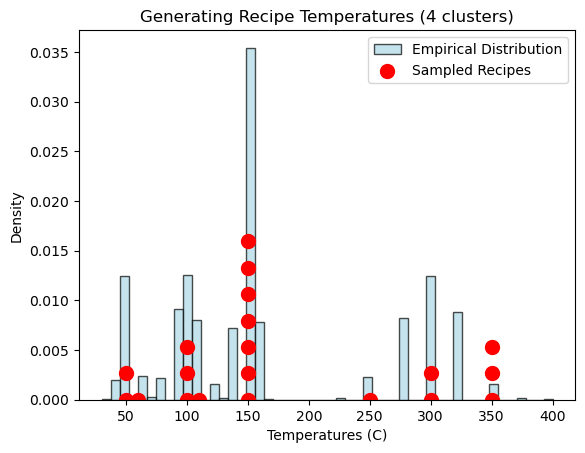

In [395]:
# Applying to Recipe Temperatures
dist_params_list = [
    {'dist_type': 'normal', 'mean': 50, 'std': 5, 'n_samples': 500, 'rounding_base': 10},    # Mode 1
    {'dist_type': 'normal', 'mean': 100, 'std': 10, 'n_samples': 1000, 'rounding_base': 10}, # Mode 2
    {'dist_type': 'normal', 'mean': 150, 'std': 5, 'n_samples': 1500, 'rounding_base': 10},  # Mode 3
    {'dist_type': 'normal', 'mean': 300, 'std': 25, 'n_samples': 1000, 'rounding_base': 25}  # Mode 4
]

min_samples_per_mode = 3  # Minimum samples per mode
n_total_samples = 20      # Total number of samples

# Call the updated function
final_samples = n_mode_sampling(
    dist_params_list=dist_params_list,  # Distribution parameters
    min_samples_per_mode=min_samples_per_mode,  # Minimum samples per mode
    n_total_samples=n_total_samples,  # Total samples
    title='Generating Recipe Temperatures (4 clusters)',  # Custom plot title
    x_label='Temperatures (C)',  # Custom x-axis label
    seed=121  # Random seed for reproducibility
    , ShowPlot=True
)


In [396]:
# Assign 'Recipe_Temperature' to both Machine columns
df['Recipe_Temperatures'] = final_samples
df['Recipe_Temperatures'] = df['Recipe_Temperatures'].astype(int)


In [397]:
# final_samples

In [398]:
### Clustering the Recipe Temperatures

## Note: 200 C is a clear gap; separate the two into separate subproblems (200+ are a cluster)

k = 3  # Number of clusters for values below 200

# Create a mask for values below 200
below_200_mask = final_samples < 200

# Apply K-means clustering to values below 200
clusters_below_200, centroids_below_200 = kmeans1d.cluster(final_samples[below_200_mask], k)

# Initialize the final clusters
final_clusters = np.full_like(final_samples, 
                              fill_value=k, # Assuming that the last cluster wasn't assigned (k)
                              dtype=int)  # Assign cluster 'k' to all

# Assign clusters to values below 200
final_clusters[below_200_mask] = clusters_below_200

print(f"Final Clusters in Original Order: {final_clusters}")
print(f"Original Values: {final_samples}")
print(f"Centroids for Below 200 Clusters: {centroids_below_200}")


Final Clusters in Original Order: [1 2 2 3 2 0 2 2 1 3 2 3 0 2 3 3 3 0 1 1]
Original Values: [100. 150. 150. 300. 150.  50. 150. 150. 110. 350. 150. 350.  60. 150.
 250. 300. 350.  50. 100. 100.]
Centroids for Below 200 Clusters: [53.333333333333336, 102.5, 150.0]


In [399]:
# Convert cluster numbers to letters for general recipe
general_recipe_letters = [chr(65 + cluster) for cluster in final_clusters] # 65 is "A" goes for only 26 letters, but this is OK for this
df['Recipe_Cluster'] = general_recipe_letters

In [400]:
# Add 'Recipe_Cluster' column
df['Recipe_Cluster'] = general_recipe_letters

# Reset index to column (Recipe appears)
df.reset_index(inplace=True)

# MultiIndex with 'Recipe_Cluster', 'Recipe', and original index
df.set_index(['Recipe_Cluster', 'Recipe'], 
             inplace=True)

# Sort by 'Recipe_Cluster' and 'Recipe'
df.sort_index(level=['Recipe_Cluster', 'Recipe'], 
              ascending=[True, True], 
              inplace=True)

# display(df)

In [401]:
# We want to worsen the setup conditions to make them more attractive for the case study. 
# We assume manufacturer demand triggers this.

# Define mask for conditions (needs to be Boolean series, not Pandas df or .loc)
mask0 = (df['Machine1_ProcessUnitsPerMinute']==0) | \
        (df['Machine2_ProcessUnitsPerMinute']==0) | \
        (df['Recipe_Temperatures']<=60) | \
        (df['Recipe_Temperatures']>=300)

# Set default OddsIncrease to 1
df['OddsIncrease'] = 1

# Increment OddsIncrease where mask0 is True
df.loc[mask0, 'OddsIncrease'] += 1

# VisitProbability weighing
sum_total = np.sum(df['OddsIncrease'])
df['VisitProbability'] = np.divide(df['OddsIncrease'], sum_total).round(6) # using np.divide to avoid floating point division issues
# Adjust the last probability for sum equals 100%
df.loc[df.index[-1], 'VisitProbability'] += 1 - df['VisitProbability'].sum() # use this method for avoiding copy/assessor warnings

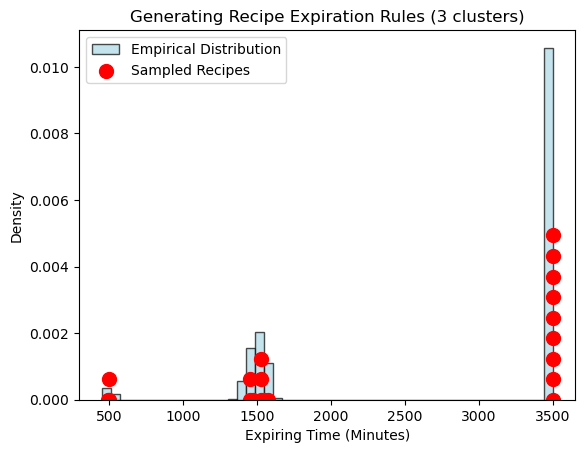

In [402]:
# For Recipe Expiration Rules
dist_params_list = [
    {'dist_type': 'poisson', 'lambda': 500, 'n_samples': 100, 'rounding_base': 10},    # Mode 1 (only a few, but restrictive!)
    {'dist_type': 'normal', 'mean': 1500, 'std': 50, 'n_samples': 1000, 'rounding_base': 25}, # Mode 2
    {'dist_type': 'normal', 'mean': 3500, 'std': 0, 'n_samples': 2000, 'rounding_base': 25},  # Mode 3 (basically no expiration, two 1/2 days schedule by the minute?)
]

min_samples_per_mode = 2  # Minimum samples per mode
n_total_samples = 20      # Total number of samples (Recipes)

# Call the updated function
recipe_expiring_samples = n_mode_sampling(
    dist_params_list=dist_params_list,  # Distribution parameters
    min_samples_per_mode=min_samples_per_mode,  # Minimum samples per mode
    n_total_samples=n_total_samples,  # Total samples
    title='Generating Recipe Expiration Rules (3 clusters)',  # Custom plot title
    x_label='Expiring Time (Minutes)',  # Custom x-axis label
    seed=200  # Random seed for reproducibility
    , ShowPlot=True)

In [403]:
# recipe_expiring_samples

In [404]:
# Assign 'Recipe_Temperature' to both Machine columns
df['Recipe_ExpiringMinutes'] = recipe_expiring_samples
df['Recipe_ExpiringMinutes'] = df['Recipe_ExpiringMinutes'].astype(int)


In [405]:
print(df.dtypes)


Machine1_ProcessUnitsPerMinute      int64
Machine2_ProcessUnitsPerMinute      int64
Recipe_Temperatures                 int64
OddsIncrease                        int64
VisitProbability                  float64
Recipe_ExpiringMinutes              int64
dtype: object


In [406]:
display(df)

Machine1_ProcessUnitsPerMinute  \
Recipe_Cluster Recipe                                   
A              6                                    2   
               13                                   0   
               18                                   7   
B              1                                    0   
               9                                    1   
               19                                   2   
               20                                   3   
C              2                                    1   
               3                                    1   
               5                                    5   
               7                                    3   
               8                                    4   
               11                                   7   
               14                                   6   
D              4                                    0   
               10                                   8   
               12                                   2   
               15                                   2   
               16                                   3   
               17                                   1   

                       Machine2_ProcessUnitsPerMinute  Recipe_Temperatures  \
Recipe_Cluster Recipe                                                        
A              6                                    5                   50   
               13                                   4                   60   
               18                                   2                   50   
B              1                                    1                  100   
               9                                    4                  110   
               19                                   5                  100   
               20                                   6                  100   
C              2                                    1                  150   
               3                                    0                  150   
               5                                    5                  150   
               7                                    7                  150   
               8                                    4                  150   
               11                                   3                  150   
               14                                   5                  150   
D              4                                    3                  300   
               10                                   4                  350   
               12                                   2                  350   
               15                                   0                  250   
               16                                   0                  300   
               17                                   2                  350   

                       OddsIncrease  VisitProbability  Recipe_ExpiringMinutes  
Recipe_Cluster Recipe                                                          
A              6                  2          0.064516                    1450  
               13                 2          0.064516                    1575  
               18                 2          0.064516                    3500  
B              1                  2          0.064516                     500  
               9                  1          0.032258                    3500  
               19                 1          0.032258                    3500  
               20                 1          0.032258                    3500  
C              2                  1          0.032258                    3500  
               3                  2          0.064516                    1525  
               5                  1          0.032258                    1550  
               7                  1          0.032258                    1525  
           

In [407]:


# save tables
def save_df(df, file_name, folder_name=None, save_as='pkl'):
    if folder_name: 
        dir_path = os.path.join('ProblemSets', folder_name)
    else: # set default folder if none are provided
        dir_path = 'ProblemSets'  # Default folder
    
    # create directory if it doesn't exist
    os.makedirs(dir_path, exist_ok=True)
    
    # construct full file path
    file_path = os.path.join(dir_path,
                             f'{file_name}.{save_as}')
    
    # save based on format
    if save_as == 'txt':
        df.to_csv(file_path, 
                  sep='\t')  # Save as txt
    else:
        df.to_pickle(file_path)  # Save as pickle
    
    # print confirmation
    print(f"Data has been saved to '{file_path}'")

# Save as .pkl (default to ProblemSets)
save_df(df, 
        'Recipes_ProcessSetupByMachine')

# # Save as .pkl in folder
# save_df(df, 
#         'Recipes_ProcessSetupByMachine',
#         '25Queue')

Data has been saved to 'ProblemSets/Recipes_ProcessSetupByMachine.pkl'


### Computing matrix to matrix setup costs

In [411]:
from scipy.integrate import odeint # For solving cooling differential equations (Newton's Law of Cooling)

# We are using Calculus!!! Ah, it's been years.
def cooling(current_temp, time, ambient_temp, cooling_rate):
    '''
    We are solving an ordinary differential equation (a simple exponential function).
        
    Newton's Law of Cooling: dT/dt = -k * (T - T_ambient)
    '''
    return -cooling_rate * (current_temp - ambient_temp)  # Returns the rate of temperature change over time (dT/dt)

# Compute transition time
def compute_cooling_heating_time(initial_temp, 
                                 final_temp, 
                                 ambient_temp_cooling, 
                                 cooling_rate, 
                                 linear_heating_rate=200, 
                                 stop_hours=4,
                                 num_timepoints=10001): # Linear heating rate (default 1 hour per 200°C) / # the number of hours expected, I had 4 given my calculations using 
    '''
    Uses the cooling differential function of Newton's Law of Cooling. Calculated the cooling rate of constant using the following website: 
    # https://calculator.academy/newtons-law-of-cooling-calculator-2/
    And by plugging in everything except for the constant. The cooling parameters were based on from 300 C to 50 C with cooling.
    Heating uses a simple linear heating rate, with a default of 1 hour per 200°C.
    '''
    time_points = np.linspace(start=0, stop=stop_hours, # hours ##
                              num=num_timepoints)  # Time points for integration

    # cooling or heating
        # JRW: could be more efficient by storing combinations that are repeated
    if initial_temp > final_temp: # Cooling: use Newton's Law
        rate_constant = cooling_rate  # Use cooling rate
        temp_solution = odeint(cooling,  # Apply cooling function
                               initial_temp,  # Initial temperature
                               time_points,  # Time points array
                               args=(ambient_temp_cooling, rate_constant))  # Additional arguments

        # While I could solve this exactly, for time-reasons numerical solution is simplest to implement

        # Find target time for cooling
        for time, temp in zip(time_points, temp_solution):  # Iterate over results
            if np.isclose(temp, 
                          final_temp,
                          atol=0.1):  # Check if final temp reached (tolerance of 0.1 based on linspace)
                return time  # Return time when temp is reached
        return time_points[-1]  # Return max time if not found
    else: # Heating: use linear time calculation 
        temp_difference = final_temp - initial_temp  # Temperature change
        time_to_heat = (temp_difference / linear_heating_rate) * 1  # Time to heat
        return time_to_heat  # Return calculated heating time

# Directly generate the DataFrame
def generate_transition_time_matrix(df, 
                                    ambient_temp_cooling, 
                                    cooling_rate, 
                                    linear_heating_rate=200): # Linear heating rate (default 1 hour per 200°C)
    recipes = df.index.tolist()  # Recipe list
    temperatures = df['Recipe_Temperatures'].values  # Temperatures

    n = len(temperatures)  # Number of recipes
    from_recipes = []  # Store from recipes
    to_recipes = []  # Store to recipes
    transition_times = []  # Store times

    # Loop through combinations
    for i in range(n):
        for j in range(n):
            initial_temp = temperatures[i]  # Initial temp
            final_temp = temperatures[j]  # Final temp
            # Compute time
            time = compute_cooling_heating_time(initial_temp, final_temp,  # Pass temperatures
                                                ambient_temp_cooling, cooling_rate, # Cooling params
                                                linear_heating_rate) # Pass linear heating rate
            from_recipes.append(recipes[i])  # Append from recipe
            to_recipes.append(recipes[j])  # Append to recipe
            transition_times.append(time)  # Append time

    # Create DataFrame
    transition_df = pd.DataFrame({
        'From_Recipe': from_recipes,  # From recipes
        'To_Recipe': to_recipes,  # To recipes
        'Transition_Time_Hours': transition_times  # Times
    })

    transition_df.set_index(['From_Recipe', 
                             'To_Recipe'], inplace=True)  # Set index

    from_temps = df['Recipe_Temperatures'].loc[transition_df.index.get_level_values('From_Recipe')].values  # From temps
    to_temps = df['Recipe_Temperatures'].loc[transition_df.index.get_level_values('To_Recipe')].values  # To temps
    transition_df['From_Temperature'] = from_temps  # Add from temp
    transition_df['To_Temperature'] = to_temps  # Add to temp

    return transition_df  # Return DataFrame

temperature_array = np.array(final_samples)  # Array of temperatures

# Cooling rate
# https://calculator.academy/newtons-law-of-cooling-calculator-2/
cooling_rate = 0.79  # Cooling rate constant (positive)
ambient_temp_cooling = 25  # ambient temp during cooling

transition_df = generate_transition_time_matrix(df, 
                                                ambient_temp_cooling, 
                                                cooling_rate,
                                                linear_heating_rate=200) # Linear heating rate (default 1 hour per 200°C)




In [412]:
# Add minutes, ROUND FOR INTEGRALITY!!! INTEGERS ARE EASIER
transition_df['Transition_Time_Minutes'] = round(transition_df['Transition_Time_Hours'] * 60,2).astype(int)  # Convert to minutes, ROUND and grab integer
transition_df

Transition_Time_Hours  From_Temperature  \
From_Recipe To_Recipe                                            
(A, 6)      (A, 6)                    0.0000                50   
            (A, 13)                   0.0500                50   
            (A, 18)                   0.0000                50   
            (B, 1)                    0.2500                50   
            (B, 9)                    0.3000                50   
...                                      ...               ...   
(D, 17)     (D, 10)                   0.0000               350   
            (D, 12)                   0.0000               350   
            (D, 15)                   0.4652               350   
            (D, 16)                   0.2112               350   
            (D, 17)                   0.0000               350   

                       To_Temperature  Transition_Time_Minutes  
From_Recipe To_Recipe                                           
(A, 6)      (A, 6)                 50                        0  
            (A, 13)                60                        3  
            (A, 18)                50                        0  
            (B, 1)                100                       15  
            (B, 9)                110                       18  
...                               ...                      ...  
(D, 17)     (D, 10)               350                        0  
            (D, 12)               350                        0  
            (D, 15)               250                       27  
            (D, 16)               300                       12  
            (D, 17)               350                        0  

[400 rows x 4 columns]

In [413]:
# Copy for Machine 2
transition_df_machine2 = transition_df.copy()

# Exclude same setups
mask = transition_df_machine2['From_Temperature'] != transition_df_machine2['To_Temperature']  # Compare temps

# Add 5 minutes
transition_df_machine2.loc[mask, 'Transition_Time_Minutes'] += 5

# Label Machine 1
transition_df['Machine'] = 1

# Label Machine 2
transition_df_machine2['Machine'] = 2 # Machine that takes 5 minutes longer for setups (symmetry breaking, realism too-- say older machine)

# Concatenate DataFrames differentiating by machine (THIS IS EXTREMELY IMPORTANT, ANYTHING SYMMETRY-BREAKING MUST BE INCLUDED)
combined_df = pd.concat([transition_df, 
                         transition_df_machine2], 
                        axis=0)
combined_df = combined_df.set_index('Machine', append=True) # add to index
combined_df = combined_df.sort_index(level=['From_Recipe', 'To_Recipe', 'Machine'])


# Display result
display(combined_df)


Transition_Time_Hours  From_Temperature  \
From_Recipe To_Recipe Machine                                            
(A, 6)      (A, 6)    1                       0.0000                50   
                      2                       0.0000                50   
            (A, 13)   1                       0.0500                50   
                      2                       0.0500                50   
            (A, 18)   1                       0.0000                50   
...                                              ...               ...   
(D, 17)     (D, 15)   2                       0.4652               350   
            (D, 16)   1                       0.2112               350   
                      2                       0.2112               350   
            (D, 17)   1                       0.0000               350   
                      2                       0.0000               350   

                               To_Temperature  Transition_Time_Minutes  
From_Recipe To_Recipe Machine                                           
(A, 6)      (A, 6)    1                    50                        0  
                      2                    50                        0  
            (A, 13)   1                    60                        3  
                      2                    60                        8  
            (A, 18)   1                    50                        0  
...                                       ...                      ...  
(D, 17)     (D, 15)   2                   250                       32  
            (D, 16)   1                   300                       12  
                      2                   300                       17  
            (D, 17)   1                   350                        0  
                      2                   350                        0  

[800 rows x 4 columns]

In [414]:
# Save as .pkl (default)
save_df(combined_df, 
        'RecipeToRecipe_Setups')

Data has been saved to 'ProblemSets/RecipeToRecipe_Setups.pkl'


In [415]:
#### Completed with Setup Matrix Low Lever!

### General Recipes into Clusters of Recipes (k means)

In [416]:
import itertools 

# sorted unique characters
chars = sorted(set(df.index.get_level_values('Recipe_Cluster')))

def cyclic_permutations(perm): 
    '''
    Generate all shifts
    cyclic_permutations(['A', 'B', 'C' ,'D']) ->

    [['A', 'B', 'C', 'D'],
     ['B', 'C', 'D', 'A'], # shifted one
     ['C', 'D', 'A', 'B'], # shifted one
     ['D', 'A', 'B', 'C']] # shifted one
    
    '''
    return [perm[i:] + perm[:i] for i in range(len(perm))]

# Store unique Hamiltonian cycles
unique_cycles = set()  # set data type

# iterate over permutations
for perm in itertools.permutations(chars):
    cycles = cyclic_permutations(perm) # get cyclic permutations
    unique_cycles.add(tuple(min(cycles))) # add smallest cycle to set

# convert to NumPy array
np_unique_cycles = list(unique_cycles)

# print result
print(np_unique_cycles)

response_df = pd.DataFrame({'UniqueRecipeClusterSequence': np_unique_cycles,
                       'SchedulingRule': np.arange(1, len(np_unique_cycles) + 1)}) # 1-based

display(response_df)

# Save as .txt
save_df(response_df, 'SchedulingRule_Permutations', 'txt')

# Save as .pkl (default)
save_df(response_df, 'SchedulingRule_Permutations')


[('A', 'B', 'C', 'D'), ('A', 'B', 'D', 'C'), ('A', 'C', 'B', 'D'), ('A', 'C', 'D', 'B'), ('A', 'D', 'B', 'C'), ('A', 'D', 'C', 'B')]


,UniqueRecipeClusterSequence,SchedulingRule
0,"(A, B, C, D)",1
1,"(A, B, D, C)",2
2,"(A, C, B, D)",3
3,"(A, C, D, B)",4
4,"(A, D, B, C)",5
5,"(A, D, C, B)",6


Data has been saved to 'ProblemSets/txt/SchedulingRule_Permutations.pkl'
Data has been saved to 'ProblemSets/SchedulingRule_Permutations.pkl'


### Generating a Job

In [417]:
#random.choice(a, size=None, replace=True, p=None)
arr_recipes = df.index.get_level_values('Recipe').values
p_recipes = df['VisitProbability']

np.random.seed(121)

# Randomly Select Recipes (Given VisitProbability)
jobs = 1
np.random.choice(a=arr_recipes,
                 replace=True, 
                 p=df['VisitProbability'], # For more interesting permutations, like 0's on processing, high or low setups
                 size=jobs)

array([13])

In [418]:
# Randomly Select Recipes (Given VisitProbability)
jobs = 1
np.random.choice(a=arr_recipes,
                 replace=True, 
                 p=df['VisitProbability'], # For more interesting permutations, like 0's on processing, high or low setups
                 size=jobs)

array([1])

In [419]:

# Subset recipes for machine
def subset_recipes(df_function, machine_col, condition):
    """
    Subsets the DataFrame based on machine condition:  Processing Time > 0 units per minute.
    """
    # Apply machine condition
    return df_function[df_function[machine_col] > condition]  # Processing Time > 0 units per minute

# Recalculate probabilities after subsetting
def recalculate_probabilities(df_function, odds_col='OddsIncrease'):
    """
    Recalculate VisitProbability to sum to 1.
    """
    # Sum odds values
    sum_total = np.sum(df_function[odds_col])
    # Normalize probabilities
    df_function.loc[:, 'VisitProbability'] = np.divide(df_function[odds_col], sum_total).round(6)
    # Adjust last row to sum exactly to 1
    df_function.loc[df_function.index[-1], 'VisitProbability'] += 1 - df_function['VisitProbability'].sum() 
    return df_function

# Generate random jobs with or without probabilities
def generate_jobs(df_function, jobs, recipe_col='Recipe', use_probabilities=False):
    """
    Generate random jobs based on probabilities or uniformly.
    """
    # Get recipe values
    arr_recipes_function = df_function.index.get_level_values(recipe_col).values
    
    if use_probabilities:
        # Sample recipes based on VisitProbability
        return np.random.choice(a=arr_recipes_function, 
                                replace=True, 
                                p=df_function['VisitProbability'].values, 
                                size=jobs)
    else:
        # Sample recipes uniformly without probabilities
        return np.random.choice(a=arr_recipes_function, 
                                replace=True, 
                                size=jobs)

# Assign jobs to machines
def assign_jobs_to_machines(df_function, jobs=1, use_probabilities=False, debug=False):
    """
    Assign initial jobs to Machine1 and Machine2, ensuring they have zero state.
    It defaults to just getting the original "job 1 and job 2" out of the gate.
    """
    # Subset/Recalculate for Machine1
    machine1_recipes = subset_recipes(df_function, 'Machine1_ProcessUnitsPerMinute', condition=0)
    machine1_recipes = recalculate_probabilities(machine1_recipes)

    # Subset/Recalculate for Machine2
    machine2_recipes = subset_recipes(df_function, 'Machine2_ProcessUnitsPerMinute', condition=0)
    machine2_recipes = recalculate_probabilities(machine2_recipes)

    # Generate jobs for Machine1
    jobs_machine1 = generate_jobs(machine1_recipes, jobs, use_probabilities=use_probabilities)
    
    # Generate jobs for Machine2
    jobs_machine2 = generate_jobs(machine2_recipes, jobs, use_probabilities=use_probabilities)

    
    if debug:
        display(machine1_recipes) #debug
        display(machine2_recipes) #debug

    return jobs_machine1, jobs_machine2

### Good unit test for error-proofing optimization!!!

def validate_jobs(jobs, jobsno_k_sets):
    '''
    This verifies that the job list and their qualifications don't cause an error.
    '''
    # Find intersection of unqualified jobs
    intersection_jobsno = set(jobs).intersection(*jobsno_k_sets)
    
    # Check if any job unqualified for all
    if intersection_jobsno: # Raise error if unqualified job/s exist in all sets
        raise ValueError(f"At least one job is unqualified for all machines--job/s: {intersection_jobsno}")
    
    return None

In [420]:
# Without using VisitProbabilities; just a blanket uniform random selection within Machine subsets
jobs_machine1, jobs_machine2 = assign_jobs_to_machines(df)
print("Current Recipe/Job for Machine1 (uniform probabilities):", jobs_machine1)
print("Current Recipe/Job for Machine2 (uniform probabilities):", jobs_machine2)

Current Recipe/Job for Machine1 (uniform probabilities): [18]
Current Recipe/Job for Machine2 (uniform probabilities): [6]


### Job Matrix Formatting (And early development code)

For the job details, we need to generate each problem independently; for now, we will start small for unit tests. 

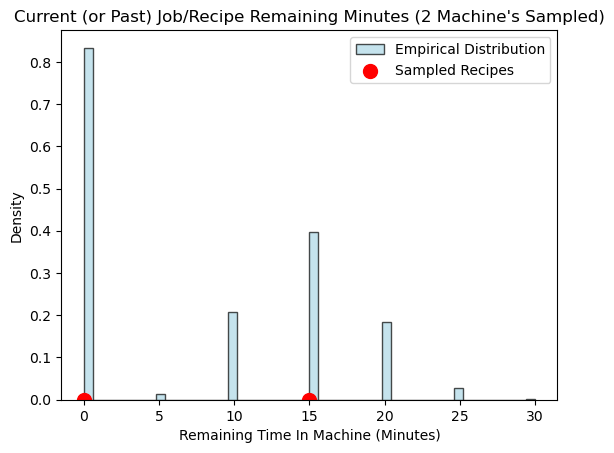

In [421]:
# For Current (Past) Job's Remaining Minutes
dist_params_list = [
    {'dist_type': 'uniform', 'low': 0, 'high': 0, 'n_samples': 10000, 'rounding_base': 1},    # Uniform distribution
    {'dist_type': 'poisson', 'lambda': 15, 'n_samples': 10000, 'rounding_base': 5},    # Poisson
]

n_total_samples = 2      # Total number of samples (Jobs)

min_samples_per_mode = 0  # Minimum samples per mode
seed_remainingtime = 200

# Call the updated function
jobs_remaining_minutes = n_mode_sampling(
    dist_params_list=dist_params_list,  # Distribution parameters
    min_samples_per_mode=min_samples_per_mode,  # Minimum samples per mode
    n_total_samples=n_total_samples,  # Total samples
    title="Current (or Past) Job/Recipe Remaining Minutes (2 Machine's Sampled)",  # Custom plot title
    x_label='Remaining Time In Machine (Minutes)',  # Custom x-axis label
    seed=seed_remainingtime  # Random seed for reproducibility
    , ShowPlot=True)

In [422]:
##  Increasing variance over time (the method for creating the lambda's for poissons)

arr = np.array([0,60,120,240,360]) # Not just a linear growth per step away

np.where((np.arange(len(arr)) > 1),  # condition: index > 1
                  arr ** np.sqrt(1.03 ** np.arange(1, len(arr)+1)),  # exponentiation
                  arr).astype(int)

array([  0,  60, 149, 335, 565])

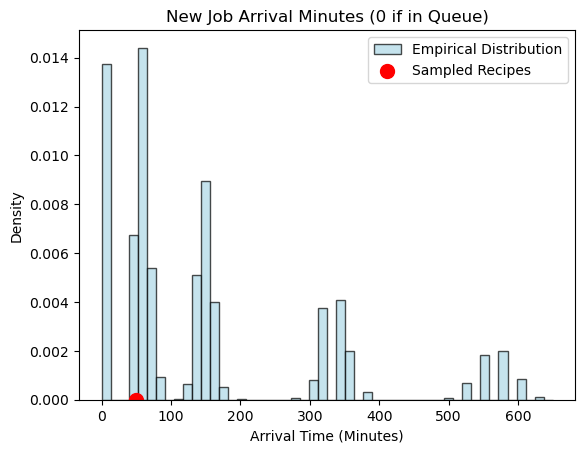

In [6]:
# For Current (Past) Job's Remaining Minutes
dist_params_list = [
    {'dist_type': 'uniform', 'low': 0, 'high': 0, 'n_samples': 2500, 'rounding_base': 1}    # Uniform distribution
    ,{'dist_type': 'poisson', 'lambda': 60, 'n_samples': 5000, 'rounding_base': 10}    # Poisson (Either 60 or 120 minutes upstream)
    ,{'dist_type': 'poisson', 'lambda': 149, 'n_samples': 3500, 'rounding_base': 15}    # Poisson (Either 60 or 120 minutes upstream) 
    ,{'dist_type': 'poisson', 'lambda': 335, 'n_samples': 2000, 'rounding_base': 20}    # Poisson (Either 60 or 120 minutes upstream)
    ,{'dist_type': 'poisson', 'lambda': 565, 'n_samples': 1000, 'rounding_base': 25},    # Poisson (Either 60 or 120 minutes upstream)
]

n_total_samples = 1      # Total number of samples (Jobs)

min_samples_per_mode = 0  # Minimum samples per mode
seed_remainingtime = 201

# Call the updated function
jobs_arrival_minutes = n_mode_sampling(
    dist_params_list=dist_params_list,  # Distribution parameters
    min_samples_per_mode=min_samples_per_mode,  # Minimum samples per mode
    n_total_samples=n_total_samples,  # Total samples
    title="New Job Arrival Minutes (0 if in Queue)",  # Custom plot title
    x_label='Arrival Time (Minutes)',  # Custom x-axis label
    seed=seed_remainingtime  # Random seed for reproducibility
    , ShowPlot=True)

In [425]:
# Without using VisitProbabilities; just a blanket uniform random selection within Machine subsets
jobs_machine1, jobs_machine2 = assign_jobs_to_machines(df)

# Randomly Select Recipes (Given VisitProbability)
jobs = 1
jobs_queue = np.random.choice(a=arr_recipes,
                 replace=True, 
                 p=df['VisitProbability'], # For more interesting permutations, like 0's on processing, high or low setups
                 size=jobs)

# Combine into a single problem
recipe_temp = np.concatenate([jobs_machine1,
                jobs_machine2,
                jobs_queue]) # Lists the Recipes per job, in order from Job 1,2,3...n

In [426]:
# Constructing Jobs table

N_jobs = recipe_temp.shape[0]
N_jobs_minus_machines = jobs_arrival_minutes.shape[0]

# Data Frame
jobs_df = pd.DataFrame({'Recipe': recipe_temp,
                       'Job':np.arange(1, N_jobs + 1)}) # 1-based

# Arrival_Minutes
arrival_minutes = np.full((N_jobs,), 0)
arrival_minutes[-N_jobs_minus_machines:] = jobs_arrival_minutes.astype(int) # fill in the RHS with simulated values
jobs_df['a']= arrival_minutes

# Remaining_Minutes
remaining_minutes = np.full((N_jobs,), np.nan)
remaining_minutes[:2] = jobs_remaining_minutes.astype(int)
jobs_df['Remaining_Minutes']= remaining_minutes 

# Units Per Job
jobs_units = np.random.randint(low=10, high=200, size=N_jobs)
jobs_df['Units'] = jobs_units


### Getting ProcessUnitsPerMinut and ExpiringMinutes (b)
# Reset indexes for copy
df_copy = df.copy().reset_index()  
jobs_df_copy = jobs_df.copy().reset_index() 

# Select columns from copy
df_subset = df_copy[['Recipe_Cluster',
                     'Recipe', 
                     'Machine1_ProcessUnitsPerMinute', 
                     'Machine2_ProcessUnitsPerMinute',
                     'Recipe_ExpiringMinutes'
                    ]]  # Keep columns

# Merge on 'Recipe'
jobs_df = pd.merge(jobs_df,
                   df_subset,
                   on='Recipe',
                   how='inner')


# Machine1: Perform division and handle NaN/inf by replacing with 10000
jobs_df['Machine1_ProcessMinutes'] = np.round(jobs_df['Units'] / jobs_df['Machine1_ProcessUnitsPerMinute'], 0)

# Replace NaN/inf with 10000
jobs_df['Machine1_ProcessMinutes'] = np.where(np.isfinite(jobs_df['Machine1_ProcessMinutes']), # useful function
                                              jobs_df['Machine1_ProcessMinutes'], 
                                              10000).astype(int) # Integrality

# Machine2: Perform division and handle NaN/inf by replacing with 10000
jobs_df['Machine2_ProcessMinutes'] = np.round(jobs_df['Units'] / jobs_df['Machine2_ProcessUnitsPerMinute'], 0)

# Replace NaN/inf with 10000
jobs_df['Machine2_ProcessMinutes'] = np.where(np.isfinite(jobs_df['Machine2_ProcessMinutes']), 
                                              jobs_df['Machine2_ProcessMinutes'], 
                                              10000).astype(int) # Integrality


# Rename columns
jobs_df = jobs_df.rename(columns={'Recipe_ExpiringMinutes': 'b'})


# Arrange columns in order
jobs_df = jobs_df[['Job','Recipe_Cluster', 'Recipe',
                   'Machine1_ProcessMinutes', 'Machine2_ProcessMinutes',
                   'a', 'b', 'Remaining_Minutes', 'Machine1_ProcessUnitsPerMinute', 'Units', 'Machine2_ProcessUnitsPerMinute'
                  ]]


display(jobs_df)

,Job,Recipe_Cluster,Recipe,Machine1_ProcessMinutes,Machine2_ProcessMinutes,a,b,Remaining_Minutes,Machine1_ProcessUnitsPerMinute,Units,Machine2_ProcessUnitsPerMinute
0,1,C,11,22,52,0,490,0.0,7,157,3
1,2,C,8,50,50,0,1475,15.0,4,199,4
2,3,A,13,10000,33,50,1575,NaN,0,131,4


In [427]:
jobs_df

,Job,Recipe_Cluster,Recipe,Machine1_ProcessMinutes,Machine2_ProcessMinutes,a,b,Remaining_Minutes,Machine1_ProcessUnitsPerMinute,Units,Machine2_ProcessUnitsPerMinute
0,1,C,11,22,52,0,490,0.0,7,157,3
1,2,C,8,50,50,0,1475,15.0,4,199,4
2,3,A,13,10000,33,50,1575,NaN,0,131,4


In [428]:
## Get the JOBSNO sets
jobs = set(jobs_df['Job'])
JOBSNO1 = set(jobs_df[jobs_df['Machine1_ProcessMinutes'] == 10000]['Job'])
JOBSNO2 = set(jobs_df[jobs_df['Machine2_ProcessMinutes'] == 10000]['Job'])



# # Example usage
# jobs = {1, 2, 3, 4, 5, 6, 7}  # All jobs
# jobsno_1 = {1, 2, 4}  # Unqualified jobs (JOBS NO) for machine 1
# jobsno_2 = {6, 3}     # Unqualified jobs for machine 2

# validate_jobs(jobs, [jobsno_1, jobsno_2])

validate_jobs(jobs=jobs,
              jobsno_k_sets=[JOBSNO1, JOBSNO2])



In [429]:

# Save as .pkl in folder
save_df(jobs_df, 
        'Problem1',
        '25Queue')


Data has been saved to 'ProblemSets/25Queue/Problem1.pkl'


In [431]:
import math

# Number of edges (E)
num_edges = lambda N: math.ceil(N * (N - 1) / 2)

# Number of tour possibilities (T)
num_tour_combinations = lambda N: int(math.factorial(N-1)/2) if N <= 8 else f"{math.factorial(N-1)/2:.1e}"

print(num_edges(5))
print(num_tour_combinations(5))

10
12


In [432]:
# Preparing the data into matrices and whatnot

In [433]:

problem_df = pd.read_pickle('Problem1.pkl')
display(problem_df)

,Job,Recipe_Cluster,Recipe,Machine1_ProcessMinutes,Machine2_ProcessMinutes,a,b,Remaining_Minutes,Machine1_ProcessUnitsPerMinute,Units,Machine2_ProcessUnitsPerMinute
0,1,A,6,12,5,0,1450,0.0,2,25,5
1,2,C,2,102,102,0,3500,15.0,1,102,1
2,3,C,3,132,10000,70,1525,NaN,1,132,0


In [434]:
## processing minutes, excluding the first k rows, they use the remaining minutes
process = np.stack([
    np.array(problem_df['Machine1_ProcessMinutes'], dtype=int),
    np.array(problem_df['Machine2_ProcessMinutes'], dtype=int)
], axis=0).T
process = process[k:]
process

array([], shape=(0, 2), dtype=int64)

In [435]:
# extracting remaining minutes in NumPy array
r = np.array(problem_df['Remaining_Minutes'][problem_df['Remaining_Minutes']>=0].values, dtype=int)
r

array([ 0, 15])

In [436]:
problem_df.shape[0]

3

In [437]:
# the cost matrix
k = 2 # number of machines
N = problem_df.shape[0] # queue size (including machines)

In [438]:
setup_df = pd.read_pickle('RecipeToRecipe_Setups.pkl').reset_index()
display(setup_df)

,From_Recipe,To_Recipe,Machine,Transition_Time_Hours,From_Temperature,To_Temperature,Transition_Time_Minutes
0,"(A, 6)","(A, 6)",1,0.0000,50,50,0
1,"(A, 6)","(A, 6)",2,0.0000,50,50,0
2,"(A, 6)","(A, 13)",1,0.0500,50,60,3
3,"(A, 6)","(A, 13)",2,0.0500,50,60,8
4,"(A, 6)","(A, 18)",1,0.0000,50,50,0
...,...,...,...,...,...,...,...
795,"(D, 17)","(D, 15)",2,0.4652,350,250,32
796,"(D, 17)","(D, 16)",1,0.2112,350,300,12
797,"(D, 17)","(D, 16)",2,0.2112,350,300,17
798,"(D, 17)","(D, 17)",1,0.0000,350,350,0


##### Arranging data for getting setup transitions

In [439]:
### repeat each row k times
problem_df_subset = problem_df[['Job', 'Recipe_Cluster', 'Recipe']] # subset the problem columns
expanded_df = pd.DataFrame(np.repeat(problem_df_subset.values, 
                                     k, 
                                     axis=0), 
                           columns=problem_df_subset.columns)

# create machine column
expanded_df['Machine'] = np.tile(np.arange(1, k+1),  # a sequence of machines (1 through k) for each original row
                                 len(problem_df_subset))

### combine using f-strings for metadata
expanded_df['RecipeMeta'] = [(c, r) for c, r in zip(expanded_df['Recipe_Cluster'], expanded_df['Recipe'])]
#display(expanded_df)

### Crossjoin to get all the permutations
crossjoin_df = pd.merge(expanded_df, expanded_df, # cross join 
                        on='Machine', # using machine as key
                        suffixes=('_from', '_to'))

setup_df_jobs = pd.merge(crossjoin_df,
                        setup_df,
                        how='left',  # left join
                        left_on=['Machine', 'RecipeMeta_from', 'RecipeMeta_to'],  # columns from left table
                        right_on=['Machine', 'From_Recipe', 'To_Recipe'])  # columns from right table
#setup_df_jobs

#### Get numpy vectorized transition matrix (i by j by k)
# unique jobs and machines
jobs = np.unique(setup_df_jobs[['Job_from', 'Job_to']].values)
machines = np.unique(setup_df_jobs['Machine'])

# map jobs and machines
job_map = {job: idx for idx, job in enumerate(jobs)}
machine_map = {machine: idx for idx, machine in enumerate(machines)}

# initialize 3D array (i by j, by k; i,j in jobs, k in machines)
transition_matrix = np.zeros((len(jobs), 
                              len(jobs), 
                              len(machines)))

# translate job and machine indices
job_from_idx = setup_df_jobs['Job_from'].map(job_map).values
job_to_idx = setup_df_jobs['Job_to'].map(job_map).values
machine_idx = setup_df_jobs['Machine'].map(machine_map).values

# fill transition matrix
transition_matrix[job_from_idx, job_to_idx, machine_idx] = setup_df_jobs['Transition_Time_Minutes'].values

# show result
transition_matrix = transition_matrix.astype(np.int64)

# # Save cost matrix
# np.save('Problem1_setup_matrix.npy', # needs to be generalized
#         transition_matrix)


In [446]:
import math

# Number of edges (E)
num_edges = lambda N: math.ceil(N * (N - 1) / 2)

# Number of tour possibilities (T)
num_tour_combinations = lambda N: int(math.factorial(N-1)/2) if N <= 8 else f"{math.factorial(N-1)/2:.1e}"

print(num_edges(5))
print(num_tour_combinations(5))

10
12


###### Preparing data into NumPy matrices (Setup_Matrix, Cost_Matrix)

In [447]:

problem_df = pd.read_pickle('Problem1.pkl')
display(problem_df)

,Job,Recipe_Cluster,Recipe,Machine1_ProcessMinutes,Machine2_ProcessMinutes,a,b,Remaining_Minutes,Machine1_ProcessUnitsPerMinute,Units,Machine2_ProcessUnitsPerMinute
0,1,A,6,12,5,0,1450,0.0,2,25,5
1,2,C,2,102,102,0,3500,15.0,1,102,1
2,3,C,3,132,10000,70,1525,NaN,1,132,0


## Generalizing Problem Generation

##### Getting Empirical Distributions for Quicker Generation

In [452]:
# For Current (Past) Job's Remaining Minutes

dist_params_list = [
    {'dist_type': 'uniform', 'low': 0, 'high': 0, 'n_samples': 10000, 'rounding_base': 1},    # Uniform distribution
    {'dist_type': 'poisson', 'lambda': 20, 'n_samples': 10000, 'rounding_base': 5},    # Poisson
]

n_total_samples = 10000      # Total number of samples (Jobs)

min_samples_per_mode = 0  # Minimum samples per mode
seed_remainingtime = 202

# Call the updated function
empirical_jobs_remaining_minutes = n_mode_sampling(
    dist_params_list=dist_params_list,  # Distribution parameters
    min_samples_per_mode=min_samples_per_mode,  # Minimum samples per mode
    n_total_samples=n_total_samples).astype(int)

In [453]:
# For Job's Arrival Minutes (Stochastic element)
dist_params_list = [
    {'dist_type': 'uniform', 'low': 0, 'high': 0, 'n_samples': 2500, 'rounding_base': 1}    # Uniform distribution
    ,{'dist_type': 'poisson', 'lambda': 60, 'n_samples': 5000, 'rounding_base': 10}    # Poisson (Either 60+ minutes steps upstream, heteroscedasticity)
    ,{'dist_type': 'poisson', 'lambda': 149, 'n_samples': 3500, 'rounding_base': 15}    # Poisson 
    ,{'dist_type': 'poisson', 'lambda': 335, 'n_samples': 2000, 'rounding_base': 25}    # Poisson 
    ,{'dist_type': 'poisson', 'lambda': 565, 'n_samples': 1000, 'rounding_base': 30},    # Poisson 
]

n_total_samples = 10000      # Total number of samples (Jobs)

min_samples_per_mode = 0  # Minimum samples per mode
seed_remainingtime = 201

# Call the updated function
empirical_jobs_arrival_minutes = n_mode_sampling(
    dist_params_list=dist_params_list,  # Distribution parameters
    min_samples_per_mode=min_samples_per_mode,  # Minimum samples per mode
    n_total_samples=n_total_samples).astype(int)

In [454]:
def Generate_job_df(df, arr_recipes, empirical_jobs_arrival_minutes, empirical_jobs_remaining_minutes, jobs, seed=None, k = 2, expected_arrival_minutes_per_step = np.array([0, 60, 149, 335, 565])): # Machines count
    """
    Fill a queue DataFrame for a scheduling problem.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing recipe and machine information.
        arr_recipes (array-like): List of recipes for random job assignment.
        empirical_jobs_arrival_minutes (array-like): Historical job arrival times.
        empirical_jobs_remaining_minutes (array-like): Historical remaining job times.
        jobs (int): Number of jobs to generate.
        seed (int, optional): Random seed for reproducibility. Default is None.
        k (int, optional): Number of machines. Default is 2.
        expected_arrival_minutes_per_step (np.array, optional): Time steps for binning arrival times. Default is [0, 60, 149, 335, 565].
    
    Returns:
        pd.DataFrame: Generated jobs DataFrame with columns for job details, processing times, and scheduling parameters.
    """
    
    if seed is not None:
        np.random.seed(seed)

    # Select jobs based on VisitProbability (Adjusts importance to encourage edge cases slightly)
    jobs_queue = np.random.choice(a=arr_recipes, 
                                  replace=True, 
                                  p=df['VisitProbability'], 
                                  size=jobs)

    # Combine jobs and machines
    recipe_temp = np.concatenate([np.concatenate(assign_jobs_to_machines(df)), jobs_queue])

    # Initialize DataFrame
    N_jobs = k + jobs
    N_jobs_minus_machines = N_jobs - k

    # Create DataFrame
    jobs_df = pd.DataFrame({'Recipe': recipe_temp, 
                            'Job': np.arange(1, N_jobs + 1)})

    # Set arrival minutes
    arrival_minutes = np.zeros(N_jobs, dtype=int)
    arrival_minutes[-N_jobs_minus_machines:] = np.sort(
        np.random.choice(empirical_jobs_arrival_minutes, size=jobs, replace=True).astype(int)
    )
    jobs_df['a_true'] = arrival_minutes  # Arrival time

    # Array to be rounded
    a_true = np.array(arrival_minutes)
    
    # Calculate the nearest rounding value
    jobs_df['a'] = expected_arrival_minutes_per_step[np.abs(a_true[:, None] - expected_arrival_minutes_per_step).argmin(axis=1)] ## vectorized binning

    # Set remaining minutes
    remaining_minutes = np.full(N_jobs, np.nan)
    
    remaining_minutes[:k] = np.random.choice(empirical_jobs_remaining_minutes, size=k, replace=True).astype(int)
    jobs_df['Remaining_Minutes'] = remaining_minutes

    # Assign units per job
    jobs_df['Units'] = np.random.randint(25, 250, size=N_jobs)

    # Merge DataFrames
    df = df.reset_index()
    df_subset = df[['Recipe_Cluster', 'Recipe', 'Machine1_ProcessUnitsPerMinute', 
                    'Machine2_ProcessUnitsPerMinute', 'Recipe_ExpiringMinutes']]
    jobs_df = pd.merge(jobs_df, 
                       df_subset, 
                       on='Recipe',
                       how='inner')

    # Calculate Machine1 ProcessMinutes
    jobs_df['Machine1_ProcessMinutes'] = np.where(
        jobs_df['Machine1_ProcessUnitsPerMinute'] > 0, 
        np.round(jobs_df['Units'] / jobs_df['Machine1_ProcessUnitsPerMinute'], 0),
        10000
    ).astype(int)  # Handle division by zero

    # Calculate Machine2 ProcessMinutes
    jobs_df['Machine2_ProcessMinutes'] = np.where(
        jobs_df['Machine2_ProcessUnitsPerMinute'] > 0, 
        np.round(jobs_df['Units'] / jobs_df['Machine2_ProcessUnitsPerMinute'], 0),
        10000
    ).astype(int)  # Handle division by zero

    # Rename column to 'b'
    jobs_df = jobs_df.rename(columns={'Recipe_ExpiringMinutes': 'b'})
    jobs_df['b'] = jobs_df['a'] + jobs_df['b']     # Add arrival minutes to 'b'
    jobs_df['b_true'] = jobs_df['a_true'] + abs(jobs_df['a'] - jobs_df['b'])     # Add arrival minutes to 'b'
    
    # designate the queue steps using column 'a'
    jobs_df['Queue_Step'] = np.digitize(jobs_df['a'], 
                                        expected_arrival_minutes_per_step) - 1 

    # Arrange columns
    jobs_df = jobs_df[['Job', 'Recipe_Cluster', 'Recipe', 
                       'Machine1_ProcessMinutes', 'Machine2_ProcessMinutes', 'Remaining_Minutes',
                       'Queue_Step', 'a', 'b', 'a_true', 'b_true',
                       'Machine1_ProcessUnitsPerMinute', 'Units', 'Machine2_ProcessUnitsPerMinute']]

    return jobs_df

##### Unit test for incapable problems 

- Was successful after 1000 trials

In [456]:
# Completed 100 problems successfully
# Completed 200 problems successfully
# Completed 300 problems successfully
# Completed 400 problems successfully
# Completed 500 problems successfully
# Completed 600 problems successfully
# Completed 700 problems successfully
# Completed 800 problems successfully
# Completed 900 problems successfully
# Completed 1000 problems successfully

# def unit_test_generate_jobs(df, arr_recipes, empirical_jobs_arrival_minutes, empirical_jobs_remaining_minutes):
#     """
#     Run unit tests on the Generate_job_df function with 1000 iterations.
#     Prints progress every 100 iterations.
#     """
#     for i in range(1000):  # Loop for 1000 problems
#         try:
#             # Generate the jobs DataFrame
#             jobs_df = Generate_job_df(df=df,
#                                       arr_recipes=arr_recipes,
#                                       empirical_jobs_arrival_minutes=empirical_jobs_arrival_minutes,
#                                       empirical_jobs_remaining_minutes=empirical_jobs_remaining_minutes,
#                                       jobs=75-k)

#             # Get the JOBSNO sets
#             jobs = set(jobs_df['Job'])
#             JOBSNO1 = set(jobs_df[jobs_df['Machine1_ProcessMinutes'] == 10000]['Job'])
#             JOBSNO2 = set(jobs_df[jobs_df['Machine2_ProcessMinutes'] == 10000]['Job'])

#             # Validate the jobs
#             validate_jobs(jobs=jobs, jobsno_k_sets=[JOBSNO1, JOBSNO2])

#             # Every 100 iterations, print the progress
#             if (i + 1) % 100 == 0:
#                 print(f"Completed {i + 1} problems successfully")

#         except Exception as e:
#             print(f"Error on iteration {i + 1}: {e}")

# # Example usage to run unit tests
# unit_test_generate_jobs(df=df,
#                         arr_recipes=arr_recipes,
#                         empirical_jobs_arrival_minutes=empirical_jobs_arrival_minutes,
#                         empirical_jobs_remaining_minutes=empirical_jobs_remaining_minutes)


#### Process and Setup combined into a total cost matrix

In [458]:
### VERSION 2

## Resolved cost_matrix bug with ChatGPT assist (it was the `process_repeated` section, it needed to have a for loop per kth dimension)

def generate_cost_matrix(problem_df, setup_df, k, M=10000):
    """
    Generates the cost matrix for job setup transitions.
    Parameters:
    problem_df (pd.DataFrame): DataFrame containing job and recipe information.
    setup_df (pd.DataFrame): DataFrame containing setup times for recipe transitions.
    k (int): Number of machines.
    
    Returns:
    np.array: 3D cost matrix (N+1, N+1, k) (jobs by jobs by machines).
    """
    
    # Derive N from problem_df
    N = problem_df['Job'].nunique()  # Number of unique jobs
    
    # Derive remaining time (r) from problem_df
    r = np.array(problem_df['Remaining_Minutes'][problem_df['Remaining_Minutes'] >= 0].values, dtype=int)
    
    # Derive process times from problem_df
    process_initial = np.stack([
        np.array(problem_df['Machine1_ProcessMinutes'], dtype=int),
        np.array(problem_df['Machine2_ProcessMinutes'], dtype=int)
    ], axis=0).T

    # Ensure that the number of rows in process matches N after slicing
    process = process_initial[k:]

    ##print(f"process\n{process}")

    # Define N (number of jobs)
    n_jobs_to_fill = N + 1  # This is N+1 to match the target shape
    n_machines = k  # Number of machines (k)

    # Use np.repeat to repeat process values correctly (needs a for loop)
    process_repeated = np.zeros((process.shape[0], 
                                 n_jobs_to_fill, 
                                 n_machines))  # Initialize 3D array
    for machine_idx in range(n_machines):
        process_repeated[:, :, machine_idx] = np.repeat(
            process[:, [machine_idx]], 
            n_jobs_to_fill, 
            axis=1
        )  # Fill each machine's slice

    ##print(f"process_repeated\n{process_repeated}")

    # Subset columns for jobs, clusters, and recipes
    problem_df_subset = problem_df[['Job', 
                                    'Recipe_Cluster', 
                                    'Recipe']]
    
    # Repeat rows k times
    expanded_df = pd.DataFrame(np.repeat(problem_df_subset.values, 
                                         k, 
                                         axis=0), 
                               columns=problem_df_subset.columns)
    
    # Add machine column
    expanded_df['Machine'] = np.tile(np.arange(1, k+1), 
                                     len(problem_df_subset))
    
    # Add metadata column
    expanded_df['RecipeMeta'] = [(c, r) for c, r in zip(expanded_df['Recipe_Cluster'], expanded_df['Recipe'])]

    # Cross join DataFrames
    crossjoin_df = pd.merge(expanded_df, expanded_df, 
                            on='Machine', 
                            suffixes=('_from', '_to'))

    # Left join with setup
    setup_df_jobs = pd.merge(crossjoin_df, setup_df, 
                             how='left', 
                             left_on=['Machine', 'RecipeMeta_from', 'RecipeMeta_to'], 
                             right_on=['Machine', 'From_Recipe', 'To_Recipe'])

    # Get unique jobs
    jobs = np.unique(setup_df_jobs[['Job_from', 'Job_to']].values.flatten())
    
    # Get unique machines
    machines = np.unique(setup_df_jobs['Machine'])

    # Map job indices
    job_map = {job: idx for idx, job in enumerate(jobs)}
    
    # Map machine indices
    machine_map = {machine: idx for idx, machine in enumerate(machines)}

    # Initialize transition matrix
    transition_matrix = np.zeros((len(jobs), len(jobs), len(machines)))

    # Get job indices
    job_from_idx = setup_df_jobs['Job_from'].map(job_map).values
    job_to_idx = setup_df_jobs['Job_to'].map(job_map).values
    
    # Get machine indices
    machine_idx = setup_df_jobs['Machine'].map(machine_map).values

    # Fill transition matrix
    transition_matrix[job_from_idx, job_to_idx, machine_idx] = setup_df_jobs['Transition_Time_Minutes'].values

    # Convert transition_matrix to int64 to avoid dtype conflicts
    transition_matrix = transition_matrix.astype(np.int64)

    # Initialize the remaining time matrix
    remaining_time_matrix = np.full((k, N+1, k), M)
    
    # Fill remaining time
    remaining_time_matrix[np.arange(k), :, np.arange(k)] = r[:, np.newaxis]

    # Initialize cost matrix
    cost_matrix = np.full((N+1, N+1, k), 0)

    # Fill remaining times
    cost_matrix[1:k+1, :, :] = remaining_time_matrix

    # Fill process times
    cost_matrix[k+1:, :, :] = process_repeated

    # Fill setup times
    mask = (cost_matrix[1:, 1:, :] < M)
    cost_matrix[1:, 1:, :][mask] += transition_matrix[mask]

    return cost_matrix.astype(int)

In [459]:

def transform_3d_array(array, M=10000):
    '''
    Takes a 3D numpy array for a cost matrix and an infeasibility number and transposes it across each k-dimension
    '''
    # Create mask for elements equal to M or np.nan
    mask = (array == M) if not np.isnan(M) else np.isnan(array)

    # Iterate over each slice along the k-dimension
    for k in range(array.shape[2]):
        mask_k = mask[:, :, k]  # Mask for k-th slice
        masked_values = np.zeros_like(array[:, :, k])  # Initialize masked values
        masked_values[mask_k] = array[:, :, k][mask_k]  # Assign masked values
        
        # Transpose masked elements (along i and j) and update the original array
        masked_values_transposed = masked_values.T  # Transpose along i, j
        array[:, :, k] = np.where(mask_k.T, masked_values_transposed, array[:, :, k])  # Update array
    
    return array



#### Orchestrate everything together

In [460]:
def main(df, arr_recipes, empirical_jobs_arrival_minutes, empirical_jobs_remaining_minutes, setup_df_path, k, job_queue, num_problems, folder_prefix='Queue'):
    """
    Main function to generate job problems, calculate cost matrices, and save them to a folder.
    
    Parameters:
    df (pd.DataFrame): DataFrame with recipe information.
    arr_recipes (np.array): Array of recipe IDs.
    empirical_jobs_arrival_minutes (np.array): Empirical distribution of job arrival minutes.
    empirical_jobs_remaining_minutes (np.array): Empirical distribution of job remaining minutes.
    setup_df_path (str): Path to the setup DataFrame pickle file.
    k (int): Number of machines.
    num_problems (int): Number of problems to generate.
    folder_prefix (str): Prefix for the folder to save the problems (default is 'Queue').
    """
    
    # Load setup DataFrame once
    setup_df = pd.read_pickle(setup_df_path).reset_index()
    
    # Loop to generate problems
    for i in range(1, num_problems + 1):
        print(f"Generating problem {i}/{num_problems}")
        
        # Generate job queue
        jobs_df = Generate_job_df(df=df,
                                  arr_recipes=arr_recipes,
                                  empirical_jobs_arrival_minutes=empirical_jobs_arrival_minutes,
                                  empirical_jobs_remaining_minutes=empirical_jobs_remaining_minutes,
                                  jobs=job_queue-k)  # Adjust job size as necessary
        
        # Save jobs DataFrame using save_df
        folder_name = f'{folder_prefix}{job_queue}'
        save_df(jobs_df, 
                file_name=f'Problem_{i}_jobs', 
                folder_name=folder_name)
        
        # Generate cost matrix
        cost_matrix_0 = generate_cost_matrix(problem_df=jobs_df, 
                                           setup_df=setup_df, 
                                           k=k)
        cost_matrix = cost_matrix_0
        cost_matrix = transform_3d_array(cost_matrix_0) # M = 10,000

        #print(f"Modified Array (k=0):\n{cost_matrix[:, :, 0]}")
        #print(f"Modified Array (k=1):\n{cost_matrix[:, :, 1]}")
        
        # Save cost matrix in the same folder
        cost_matrix_file = os.path.join('ProblemSets', 
                                        folder_name, 
                                        f'Problem_{i}_cost_matrix.npy')
        np.save(cost_matrix_file, cost_matrix)
        
        print(f"Problem {i} saved: Jobs and Cost Matrix ({cost_matrix_file})")

# Generating Problem Sets 

- Random Seed IS Important! RUN ALL CODES BEGINNING TO END (Do not change order or it will be different results)

In [462]:
# Set common parameters
common_params = {
    'df': df,
    'arr_recipes': arr_recipes,
    'empirical_jobs_arrival_minutes': empirical_jobs_arrival_minutes,
    'empirical_jobs_remaining_minutes': empirical_jobs_remaining_minutes,
    'setup_df_path': 'RecipeToRecipe_Setups.pkl',
    'k': 2  # machines
}

# Job queue configurations for training and evaluation
training_configs = [
    {'job_queue': 10, 'num_problems': 750, 'training': 'Training_'},
    {'job_queue': 25, 'num_problems': 300, 'training': 'Training_'},
    {'job_queue': 50, 'num_problems': 150, 'training': 'Training_'},
    {'job_queue': 75, 'num_problems': 100, 'training': 'Training_'}
]

evaluation_configs = [
    {'job_queue': 25, 'num_problems': 300, 'training': ''},
    {'job_queue': 50, 'num_problems': 150, 'training': ''},
    {'job_queue': 75, 'num_problems': 100, 'training': ''}
]

# Run training configns with seed 777
np.random.seed(777)
for config in training_configs:
    main(
        **common_params,
        job_queue=config['job_queue'],
        num_problems=config['num_problems'],
        folder_prefix=f"{config['training']}Queue"
    )

# Run evaluation configs with seed 7
np.random.seed(7)
for config in evaluation_configs:
    main(
        **common_params,
        job_queue=config['job_queue'],
        num_problems=config['num_problems'],
        folder_prefix=f"{config['training']}Queue"
    )

Generating problem 1/750
Data has been saved to 'ProblemSets/Training_Queue10/Problem_1_jobs.pkl'
Problem 1 saved: Jobs and Cost Matrix (ProblemSets/Training_Queue10/Problem_1_cost_matrix.npy)
Generating problem 2/750
Data has been saved to 'ProblemSets/Training_Queue10/Problem_2_jobs.pkl'
Problem 2 saved: Jobs and Cost Matrix (ProblemSets/Training_Queue10/Problem_2_cost_matrix.npy)
Generating problem 3/750
Data has been saved to 'ProblemSets/Training_Queue10/Problem_3_jobs.pkl'
Problem 3 saved: Jobs and Cost Matrix (ProblemSets/Training_Queue10/Problem_3_cost_matrix.npy)
Generating problem 4/750
Data has been saved to 'ProblemSets/Training_Queue10/Problem_4_jobs.pkl'
Problem 4 saved: Jobs and Cost Matrix (ProblemSets/Training_Queue10/Problem_4_cost_matrix.npy)
Generating problem 5/750
Data has been saved to 'ProblemSets/Training_Queue10/Problem_5_jobs.pkl'
Problem 5 saved: Jobs and Cost Matrix (ProblemSets/Training_Queue10/Problem_5_cost_matrix.npy)
Generating problem 6/750
Data has b